In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import glob
from google.colab import drive
import csv
import scipy.io.wavfile as wav
import pandas as pd

In [ ]:


# # Step 1: Mount Google Drive (If files are stored in Drive)
# drive.mount('/content/drive')

# # Step 2: Define the directory where your .wav files are stored
# # Change this path based on your Google Drive folder
# wav_dir = "/content/drive/MyDrive/Bowel Sound Data/Healthy"

# # Step 3: Get all .wav files from the directory
# wav_files = glob.glob(os.path.join(wav_dir, "*.wav"))

# # Step 4: Check if there are .wav files
# if not wav_files:
#     print("No .wav files found in the directory.")
# else:
#     print(f"Found {len(wav_files)} .wav files.")

# # Step 5: Play each .wav file one by one
# for wav_file in wav_files:
#     print(f"Playing: {os.path.basename(wav_file)}")
#     display(Audio(wav_file, autoplay=True))


In [ ]:
FRAME_SIZE = 441
HOP_SIZE = 110

In [ ]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(7,3))
    librosa.display.specshow(Y,
                             sr=sr,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

In [ ]:
def calculate_pitch(signal, sample_rate):
    # Load audio file
    # signal, sample_rate = librosa.load(wav_file, sr=None)

    # Compute Short-Time Fourier Transform (STFT)
    stft = np.abs(librosa.stft(signal))

    # Extract pitch using librosa's piptrack
    pitches, magnitudes = librosa.piptrack(S=stft, sr=sample_rate)

    # Select the maximum pitch for each frame
    pitch_values = []
    for i in range(pitches.shape[1]):
        index = np.argmax(magnitudes[:, i])  # Get index of max magnitude
        pitch = pitches[index, i]
        if pitch > 0:  # Ignore zero values (unvoiced frames)
            pitch_values.append(pitch)

    # Compute average pitch
    if len(pitch_values) == 0:
        return None  # No detected pitch

    avg_pitch = np.mean(pitch_values)
    return avg_pitch



In [ ]:
def calculate_shimmer(signal, sample_rate):
    # Load audio file
    # sample_rate, signal = wav.read(wav_file)

    # If stereo, convert to mono
    if len(signal.shape) > 1:
        signal = signal[:, 0]  # Take one channel

    # Normalize signal
    signal = signal / np.max(np.abs(signal))

    # Detect amplitude peaks
    peaks = np.where((signal[1:-1] > signal[:-2]) & (signal[1:-1] > signal[2:]))[0] + 1
    amplitudes = np.abs(signal[peaks])

    if len(amplitudes) < 2:
        return None  # Not enough peaks to compute shimmer

    # Compute shimmer: mean absolute difference of peak amplitudes
    shimmer = np.mean(np.abs(np.diff(amplitudes)) / np.mean(amplitudes)) * 100

    return shimmer

In [ ]:
def calculate_hnr(signal, sample_rate):
    # Load audio file
    # signal, sample_rate = librosa.load(wav_file, sr=None)

    # Compute Short-Time Fourier Transform (STFT)
    stft = librosa.stft(signal)
    magnitude = np.abs(stft)

    # Compute Harmonic and Noise Components
    harmonic, noise = librosa.decompose.hpss(magnitude)  # Harmonic-Percussive Separation

    # Compute power of harmonic and noise components
    P_h = np.sum(harmonic**2)
    P_n = np.sum(noise**2)

    if P_n == 0:  # Avoid division by zero
        return float('inf')  # Perfectly harmonic signal

    # Compute HNR in decibels (dB)
    hnr = 10 * np.log10(P_h / P_n)

    return hnr

In [ ]:
def calculate_zcr(y, sr):
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))

  return zcr

In [ ]:
def calculate_jitter(signal, sample_rate):
    if len(signal.shape) > 1:
        signal = signal[:, 0]  # Take one channel

    # Normalize signal
    signal = signal / np.max(np.abs(signal))

    # Compute zero-crossing times
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    times = zero_crossings / sample_rate  # Convert to time in seconds

    # Compute time differences (jitter)
    time_diffs = np.diff(times)
    jitter = np.std(time_diffs)  # Standard deviation of time intervals

    return jitter

In [ ]:
def calculate_mfcc(y, sr):
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
  mfcc = np.mean(mfccs)
  return mfcc


In [ ]:
def spectrogram(sample, sr):
  S_scale = librosa.stft(sample, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
  Y_scale = np.abs(S_scale) ** 2
  Y_log_scale = librosa.power_to_db(Y_scale)
  plot_spectrogram(Y_log_scale, sr, HOP_SIZE, y_axis="log")

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
sample, sr = librosa.load("/content/drive/MyDrive/Bowel_Sound_Data/Pathogenic/S/0_c.wav")
mfcc = calculate_zcr(sample, sr)
print(mfcc)

0.01123046875


In [ ]:
sample, sr = librosa.load(path+"/"+files[0])
# jitter = calculate_jitter(sample, sr)
# zcr = calculate_zcr(sample, sr)
# shimmer = calculate_shimmer(sample, sr)
# hnr = calculate_hnr(sample, sr)
# pitch = calculate_pitch(sample, sr)
mfcc = calculate_zcr(sample,sr)
print(mfcc)

NameError: name 'path' is not defined

In [ ]:
with open("healthy.csv", mode="w", newline="") as file:
  writer = csv.writer(file)
  writer.writerow(["sr", "jitter", "shimmer", "pitch", "hnr", "zcr", "mfcc"])

In [ ]:
# path = os.getcwd();
path = "/content/drive/MyDrive/Bowel_Sound_Data/Healthy/nan"
dir_list = os.listdir(path);

files = [f for f in dir_list if f.endswith(('.wav'))]

for item in files:
  sample, sr = librosa.load(path+"/"+item)
  jitter = calculate_jitter(sample, sr)
  zcr = calculate_zcr(sample, sr)
  shimmer = calculate_shimmer(sample, sr)
  hnr = calculate_hnr(sample, sr)
  pitch = calculate_pitch(sample, sr)
  mfcc = calculate_mfcc(sample, sr)
  with open("healthy.csv", mode="a", newline="") as file:
    writer = csv.writer(file)
    writer.writerow([sr, jitter, shimmer, pitch, hnr, zcr, mfcc])



In [ ]:
with open("unhealthyBC.csv", mode="w", newline="") as file:
  writer = csv.writer(file)
  writer.writerow(["sr", "jitter", "shimmer", "pitch", "hnr", "zcr", "mfcc"])

In [ ]:
# path = os.getcwd();
path = "/content/drive/MyDrive/Bowel_Sound_Data/Pathogenic/S"
dir_list = os.listdir(path);

files = [f for f in dir_list if f.endswith(('.wav'))]

for item in files:
  sample, sr = librosa.load(path+"/"+item)
  jitter = calculate_jitter(sample, sr)
  zcr = calculate_zcr(sample, sr)
  shimmer = calculate_shimmer(sample, sr)
  hnr = calculate_hnr(sample, sr)
  pitch = calculate_pitch(sample, sr)
  mfcc = calculate_mfcc(sample, sr)
  with open("unhealthy.csv", mode="a", newline="") as file:
    writer = csv.writer(file)
    writer.writerow([sr, jitter, shimmer, pitch, hnr, zcr, mfcc])

In [ ]:
path = "/content/drive/MyDrive/Bowel_Sound_Data/Pathogenic/bc"
dir_list = os.listdir(path);

files = [f for f in dir_list if f.endswith(('.wav'))]

for item in files:
  sample, sr = librosa.load(path+"/"+item)
  jitter = calculate_jitter(sample, sr)
  zcr = calculate_zcr(sample, sr)
  shimmer = calculate_shimmer(sample, sr)
  hnr = calculate_hnr(sample, sr)
  pitch = calculate_pitch(sample, sr)
  mfcc = calculate_mfcc(sample, sr)
  print(shimmer)
  with open("unhealthyBC.csv", mode="a", newline="") as file:
    writer = csv.writer(file)
    writer.writerow([sr,jitter,shimmer,pitch,hnr,zcr,mfcc])

3.7276703864336014


In [ ]:
df=pd.read_csv(r'/content/drive/MyDrive/Bowel_Sound_Data/data.csv')

In [ ]:
df.head()

,sr,jitter,shimmer,pitch,hnr,zcr,mfcc,label
0,22050,0.017825,3.615654,301.72330,27.232807,0.009642,-35.699406,1
1,22050,0.039251,2.999469,306.31770,24.489889,0.004333,-35.151886,1
2,22050,0.036580,1.501361,155.15536,24.960632,0.003311,-35.011490,1
3,22050,0.022709,1.912195,381.37710,9.213717,0.005276,-32.480843,1
4,22050,0.058314,3.060950,211.59805,13.171637,0.001908,-13.123498,1


In [ ]:
df.isnull().sum()

,0
sr,0
jitter,0
shimmer,0
pitch,171
hnr,0
zcr,0
mfcc,0
label,0


In [ ]:
df['pitch'].fillna(df['pitch'].median(),inplace=True)
df.isnull().sum()


<ipython-input-89-b5bb3ab92c3a>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pitch'].fillna(df['pitch'].median(),inplace=True)


,0
sr,0
jitter,0
shimmer,0
pitch,0
hnr,0
zcr,0
mfcc,0
label,0


In [ ]:
df['label'].value_counts()

,count
label,
1,411
0,242


In [ ]:
df.shape


(652, 8)

In [ ]:
X = df.drop(columns=['sr','pitch', 'hnr', 'zcr', 'mfcc', 'label'], axis=1)
X.head()

,jitter,shimmer
1,0.039251,2.999469
2,0.036580,1.501361
3,0.022709,1.912195
4,0.058314,3.060950
5,0.032468,1.747869


In [ ]:
Y = df['label']

,label
1,1
2,1
3,1
4,1
5,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y,random_state=1)

In [ ]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(521, 4) (131, 4) (521,) (131,)


In [ ]:
model=LogisticRegression()

In [ ]:
model.fit(X_train,Y_train)

LogisticRegression()

In [ ]:
X_train_prediction=model.predict(X_train)
training_accuracy=accuracy_score(X_train_prediction,Y_train)
print('Accuracy on Training Data LOGISTICREGRESSION: ',training_accuracy)

Accuracy on Training Data LOGISTICREGRESSION:  0.708253358925144


Accuracy:  0.7070552147239264
0.9048780487804878


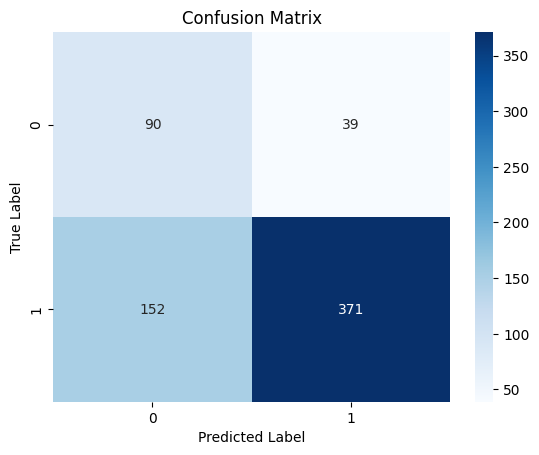

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
X_pred= model.predict(X)
accuracy = accuracy_score(X_pred, Y)
print("Accuracy: ", accuracy)
precision = precision_score(X_pred,Y)
print(precision)

cm = confusion_matrix(X_pred, Y)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
X_test_prediction=model.predict(X_test)
test_accuracy=accuracy_score(X_test_prediction,Y_test)
print('Accuracy on test Data LOGISTICREGRESSION: ',test_accuracy)

Accuracy on test Data LOGISTICREGRESSION:  0.7022900763358778


In [ ]:
X = df.drop(columns=['sr','zcr','jitter','shimmer', 'pitch', 'label'], axis=1)
y=df['label']
X.head()

,hnr,mfcc
1,24.489889,-35.151886
2,24.960632,-35.011490
3,9.213717,-32.480843
4,13.171637,-13.123498
5,21.213036,-27.204412
